#### vector import

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import math
import umap
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.image as img
from matplotlib.image import imread

from PIL import Image,ImageOps

from sklearn.decomposition import PCA

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import torch
from scipy.spatial import distance
from sklearn.metrics.pairwise import euclidean_distances
import pickle

In [2]:
base_path = '/home/jinny/projects/Art-history/Art-history/datas/'
file_info = pd.read_csv(base_path+'file_info.csv')

# file_info_latent
df = pd.DataFrame(( np.load(base_path+'vectors/avec_latents.npy', allow_pickle=True)),columns=['avec','Path'])
file_info_latents = pd.merge(file_info, df, how = 'left', on = 'Path')
file_info_latents = file_info_latents[~file_info_latents.avec.isnull()]

avec = np.array([i.reshape(-1) for i in file_info_latents['avec']])

In [3]:
df = pd.DataFrame(np.load(base_path+'vectors/cvec_latents.npy', allow_pickle=True),columns=['cvec','Path'])
file_info_latents = pd.merge(file_info_latents, df, how = 'left', on = 'Path')

cvec = np.array([i.reshape(-1) for i in file_info_latents['cvec']])

In [4]:
with open(base_path+'words/tokens.pkl', 'rb') as file:
    tokens = pickle.load(file)

In [5]:
with open(base_path+'vectors/diffusion/diffusion_sample.pkl', 'rb') as file:
    painting = pickle.load(file)

In [6]:
using_prompt = defaultdict(dict)
using_noprompt = defaultdict(dict)

for vec in ['avec','cvec','img'] :
    vec_path = f'vectors/diffusion/no_comma/{vec}/'
    for step in ['step5','step10','step20','step30'] :
        with open(base_path + vec_path + step+'/using_prompt.pkl', 'rb') as file:
            using_prompt[vec][step] = pickle.load(file)

for vec in ['avec','cvec','img'] :
    vec_path = f'vectors/diffusion/no_comma/{vec}/'
    for step in ['step5','step10','step20','step30'] :
        with open(base_path + vec_path + step+'/using_noprompt.pkl', 'rb') as file:
            using_noprompt[vec][step] = pickle.load(file)

#### diffusion import

In [7]:
import os
os.chdir("./scripts")

In [8]:
import argparse, os
import PIL
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm, trange
from itertools import islice
from einops import rearrange, repeat
from torchvision.utils import make_grid
from torch import autocast
from contextlib import nullcontext
from pytorch_lightning import seed_everything
from imwatermark import WatermarkEncoder
import pandas as pd
from scripts.txt2img import put_watermark
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler

import matplotlib.pyplot as plt
import matplotlib.image as img
from matplotlib.image import imread

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec

/home/jinny/anaconda3/envs/history/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [9]:
def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())

def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model.cuda()
    model.eval()
    return model

def load_model(device_num) :
    base_path = '/home/jinny/projects/Art-history/Art-history/'
    config = OmegaConf.load(base_path+f"scripts/configs/stable-diffusion/v2-inference.yaml")
    model = load_model_from_config(config, base_path+f"scripts/configs/checkpoint/512-base-ema.ckpt") 

    GPU_NUM = device_num # 원하는 GPU 번호 입력
    
    # GPU 할당 변경하기
    device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
    torch.cuda.set_device(device) # change allocation of current GPU
    print ('Current cuda device ', torch.cuda.current_device()) # check
    
    model = model.to(device)
    return model,device

def load_img(path):
    image = Image.open(path).convert("RGB")
    w, h = image.size
    print(f"loaded input image of size ({w}, {h}) from {path}")
    w, h = map(lambda x: x - x % 64, (w, h))  # resize to integer multiple of 64
    image = image.resize((w, h), resample=PIL.Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2. * image - 1.

In [10]:
def model_2latent(path,model) :
    file_info = pd.read_csv(base_path+'file_info.csv')

    image_latent = list()
    for i in path :
        init_image = load_img(base_path+'resized_image/'+i).to(device)
        init_latent = model.get_first_stage_encoding(model.encode_first_stage(init_image))
        init_latent = init_latent.view([-1])
        image_latent.append(init_latent.cpu().numpy())

    #latent_df = pd.DataFrame(image_latent)
    return image_latent

def model_2img(latent_samples, model) :
    precision_scope = autocast 
    with torch.no_grad():
        with precision_scope("cuda"):
            with model.ema_scope():
                
                x_samples = model.decode_first_stage(latent_samples)
                x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)

                for x_sample in x_samples:
                    x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                    img = Image.fromarray(x_sample.astype(np.uint8))
                    #img = put_watermark(img, wm_encoder)
                    return img
                    # plt.imshow(img)
                    # plt.show()

In [11]:
def run_diffusion_model_changing_denoising_steps(init_latent,prompt,n,num,batch,model,device,step):  

    seed_everything(42)
    
    ddim_steps = 50
    ddim_eta = 0.0
    n_iter = 1
    batch_size = batch
    scale = 9.0
    
    sampler = DDIMSampler(model)
    sampler.make_schedule(ddim_num_steps=ddim_steps, ddim_eta=ddim_eta, verbose=False)
    precision_scope = autocast
    
    all_samples = []
    all_samples_enc = []
    for i in range(n):
        #strength = 0.8
        strength = 1/ddim_steps * (i+num) # change strength to control denoising steps
        data = [batch_size * [prompt]]
        t_enc = step
        sampler.make_schedule(ddim_num_steps=ddim_steps, ddim_eta=ddim_eta, verbose=False)
        with torch.no_grad():
            with precision_scope("cuda"):
                with model.ema_scope():
                    for n in trange(n_iter, desc="Sampling"):
                        for prompts in tqdm(data, desc="data"):
                            uc = None
                            if scale != 1.0:
                                uc = model.get_learned_conditioning(batch_size * [""])
                            if isinstance(prompts, tuple):
                                prompts = list(prompts)
                            c = model.get_learned_conditioning(prompts)
                            if prompt == "no prompt" :
                                print("change prompt vector to zero")
                                c = torch.zeros(c.shape[0], c.shape[1], c.shape[2]).to('cuda:1') # change prompt vector to zero (i.e., no direction)

                            # encode (scaled latent)
                            z_enc = sampler.stochastic_encode(init_latent, torch.tensor([t_enc] * batch_size).to(device))
                            # decode it
                            samples = sampler.decode(z_enc, c, t_enc, unconditional_guidance_scale=scale,
                                                     unconditional_conditioning=uc, )

                            x_samples = model.decode_first_stage(samples)
                            x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)
                            
        #draw_image(x_samples[0])
        all_samples.append(x_samples)
        all_samples_enc.append(samples)
               
    return all_samples_enc

In [12]:
# model load
model,device = load_model(4)

Loading model from /home/jinny/projects/Art-history/Art-history/scripts/configs/checkpoint/512-base-ema.ckpt
Global Step: 875000
LatentDiffusion: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 1024 and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 1024 and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 1024 and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 1024 and using 10 heads.
Setting up MemoryEfficientC

# regression

In [13]:
import sklearn
from xgboost import XGBClassifier
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from xgboost import plot_importance

In [14]:
import xgboost as xgb

cvec_xgb_model = xgb.XGBRegressor()
cvec_xgb_model.load_model(base_path+"models/cvec_xgb_model.json")

In [15]:
y_ori = list()
for year in [1500, 1600, 1700, 1800] :
    y_ori.extend([int((file_info_latents['new_date'][file_info_latents['Path']==i[1]].values[0]%1500)/10) for i in painting[year]])

In [16]:
y_pre_diff = dict()

y_pre_diff[5] = defaultdict(list)
y_pre_diff[10] = defaultdict(list)
y_pre_diff[20] = defaultdict(list)
y_pre_diff[30] = defaultdict(list)

for year in [1500, 1600, 1700, 1800] :
    for step in [5,10,20,30] :
        y_pre_diff[step]['u_prompt'].extend(cvec_xgb_model.predict(pd.DataFrame(np.array([np.array(i.reshape(-1).cpu()) for i in using_prompt['cvec'][f'step{step}'][year]]))))
        y_pre_diff[step]['u_noprompt'].extend(cvec_xgb_model.predict(pd.DataFrame(np.array([np.array(i.reshape(-1).cpu()) for i in using_noprompt['cvec'][f'step{step}'][year]]))))

### graph-abcd

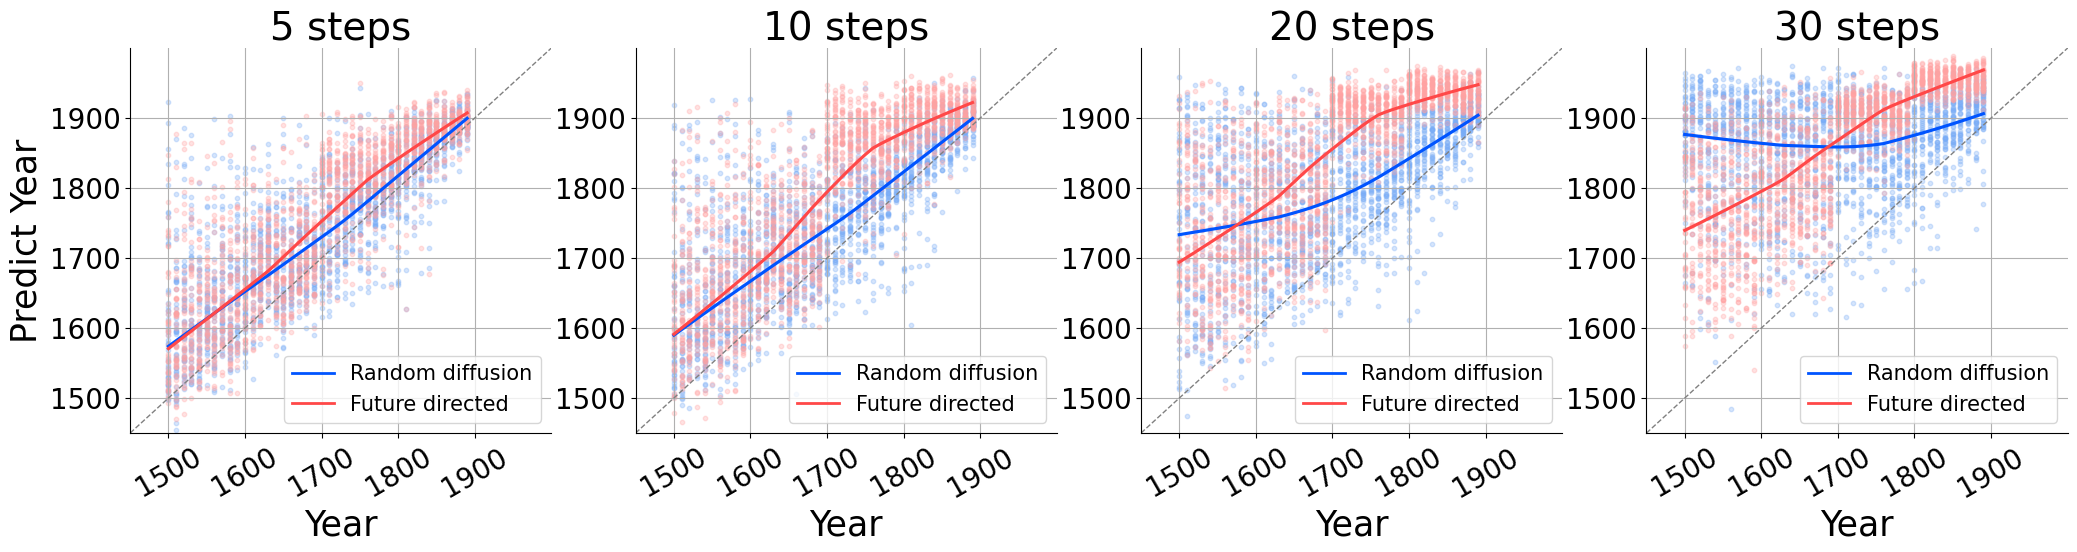

In [17]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 4, figsize=(25, 5))

blue_l = '#0054FF'
blue_s = '#78ACF6'
red_l = '#FF4848'
red_s = '#FFA2A2'

for idx, step in enumerate([5, 10, 20, 30]):
    sns.regplot(
        x=y_ori,
        y=y_pre_diff[step]['u_noprompt'],
        scatter_kws={'s': 10, 'alpha': 0.3, 'color': blue_s},
        line_kws={'color': blue_l},
        ax=ax[idx],
        lowess=True,
    )
    sns.regplot(
        x=y_ori,
        y=y_pre_diff[step]['u_prompt'],
        scatter_kws={'s': 10, 'alpha': 0.3, 'color': red_s},
        line_kws={'color': red_l},
        ax=ax[idx],
        lowess=True,
    )

# 범례 라인 생성
legend_elements = [
    Line2D([0], [0], color=blue_l, lw=2, label='Random diffusion'),
    Line2D([0], [0], color=red_l, lw=2, label='Future directed'),
]

for i in range(4):
    ax[i].plot([-5, 55], [-5, 55], color='gray', linestyle='--', linewidth=1)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_xlabel('Year', fontsize=25)
    ax[0].set_ylabel('Predict Year', fontsize=25)
    ax[i].set_xlim(-5, 50)
    ax[i].set_ylim(-5, 50)
    ax[i].set_xticks([0, 10, 20, 30, 40], [1500, 1600, 1700, 1800, 1900], rotation=30, fontsize=20)
    ax[i].set_yticks([0, 10, 20, 30, 40], [1500, 1600, 1700, 1800, 1900], fontsize=20)
    ax[i].grid(True)
    ax[i].legend(handles=legend_elements, fontsize=15)

ax[0].set_title('5 steps', fontsize=28)
ax[1].set_title('10 steps', fontsize=28)
ax[2].set_title('20 steps', fontsize=28)
ax[3].set_title('30 steps', fontsize=28)

plt.savefig('/home/jinny/projects/Art-history/Art-history/graph/figure05_ABCD.svg', bbox_inches='tight', transparent=True, dpi=600)
plt.show()


# Diffusion

In [18]:
painting_sample = dict()
painting_sample[1500] = 31
painting_sample[1600] = 31
painting_sample[1700] = 70
painting_sample[1800] = 200

Artists2/Vittore Carpaccio/The Agony In The Garden 1502.jpg


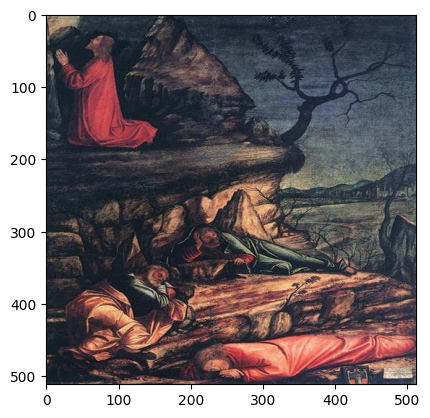

Artists1/Juan Pantoja de la Cruz/Infanta Ana Mauricia##lQG8rW94w_soYQ.jpg


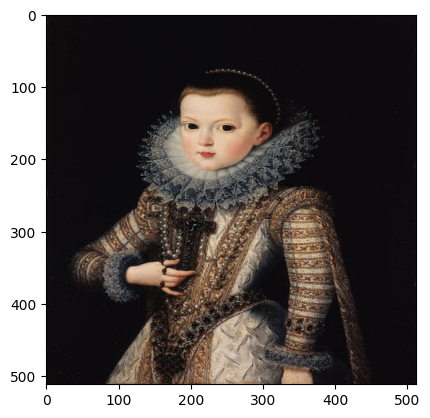

Artists1/Luca Carlevarijs/Capriccio With Scenes Of Life In A Seaport##SAFyJqN7JhJh8g.jpg


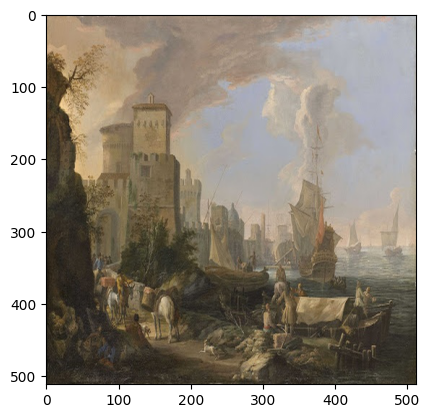

Artists2/Maxim Vorobiev/Oak Fractured By A Lightning Allegory On The Artist S Wife Death 1842.jpg


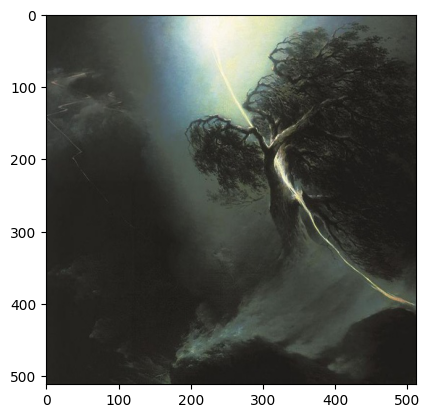

In [19]:
for year in [1500,1600,1700,1800] : 
    plt.imshow(plt.imread(base_path+'resized_image/'+painting[year][painting_sample[year]][1]))
    print(painting[year][painting_sample[year]][1])
    plt.show()

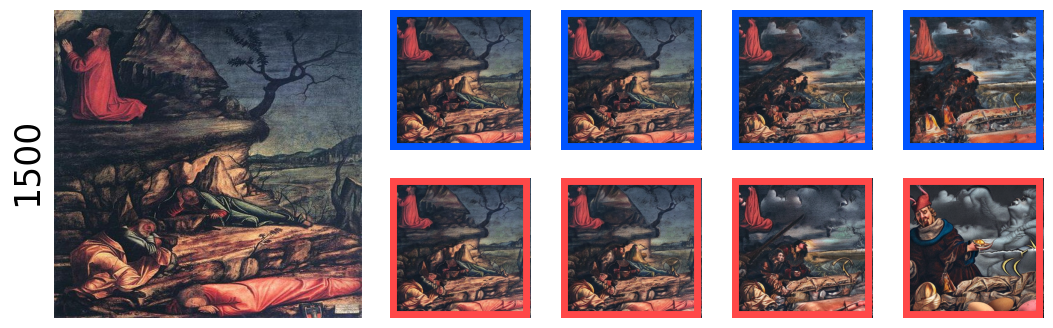

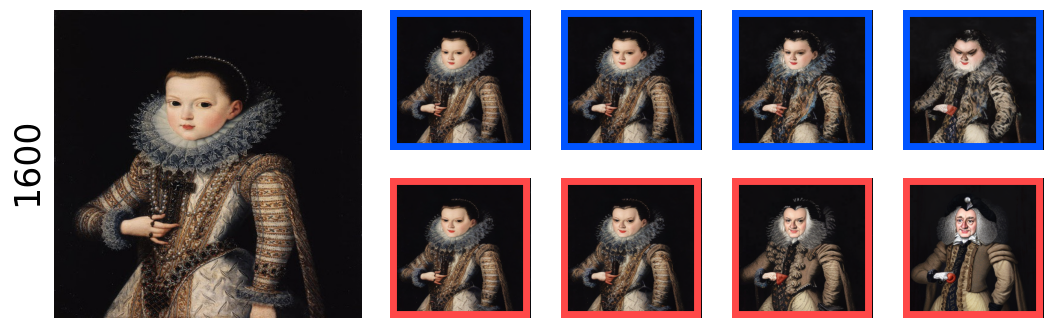

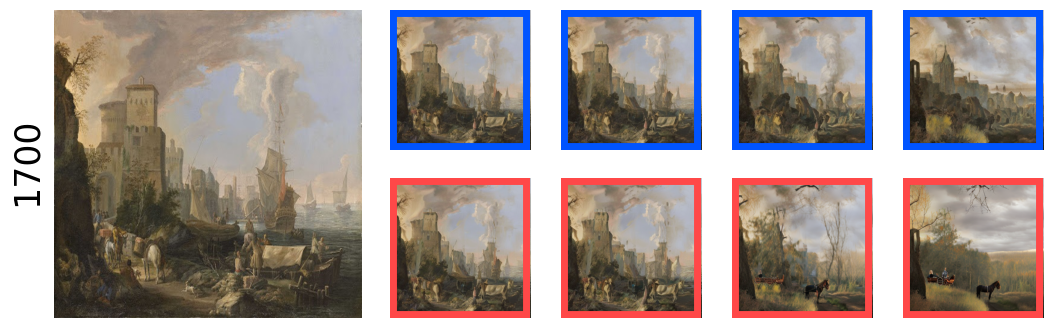

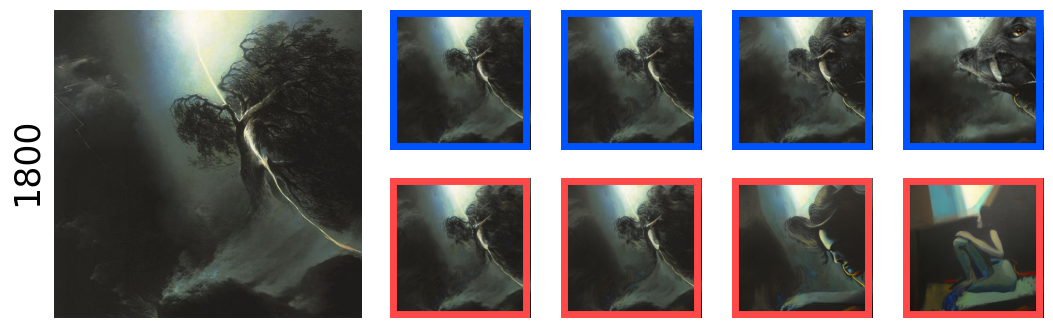

In [20]:
from matplotlib.patches import Rectangle

for year in [1500,1600,1700,1800] :
    fig = plt.figure(figsize=(13, 4))
    gs = GridSpec(2, 5, figure=fig, width_ratios=[2, 1, 1, 1, 1], height_ratios=[1, 1])
    
    # 첫 번째 큰 그림 (original)
    img = plt.imread(base_path+'resized_image/'+painting[year][painting_sample[year]][1])
    ax1 = fig.add_subplot(gs[:, 0])  # 첫 번째 열 전체 사용
    ax1.imshow(img)
    ax1.axis('off')  
    # if year == 1500 : ax1.set_title('Original', fontsize=25)
    fig.text(0.11, 0.5, f"{year}", fontsize=25, va='center', ha='center', rotation=90)

    
    # 나머지 작은 그림들
    i = 0 
    for j,step in enumerate(['step5','step10','step20','step30']):
        img = using_noprompt['img'][step][year][painting_sample[year]]
        ax = fig.add_subplot(gs[i, j + 1])  # 나머지 영역에 채움
        ax.imshow(img)
        ax.axis('off')  
        # 테두리 추가
        rect = Rectangle((0, 0), 1, 1, transform=ax.transAxes, linewidth=10, edgecolor=blue_l, facecolor='none')
        ax.add_patch(rect)
    
    i = 1
    for j,step in enumerate(['step5','step10','step20','step30']):
        img = using_prompt['img'][step][year][painting_sample[year]]
        ax = fig.add_subplot(gs[i, j + 1])  # 나머지 영역에 채움
        ax.imshow(img)
        ax.axis('off')
        # 테두리 추가
        rect = Rectangle((0, 0), 1, 1, transform=ax.transAxes, linewidth=10, edgecolor=red_l, facecolor='none')
        ax.add_patch(rect)
    
    # 간격 조정
    gs.update(wspace=0.05, hspace=0.2)
    plt.savefig(f'/home/jinny/projects/Art-history/Art-history/graph/figure05_E_{year}.svg',bbox_inches='tight',transparent = True,dpi=600)
    plt.show()

# Time vetor

#### make time vector

In [21]:
time_vec = file_info_latents['cvec'][file_info_latents['new_date'].isin([1900+i*10 for i in range(10)])].values.mean() - file_info_latents['cvec'][file_info_latents['new_date'].isin([1500+i*10 for i in range(10)])].values.mean()

In [22]:
original_time = dict()
for year in [1500,1600,1700,1800] :
    paths =list()
    for path in painting[year] :
        paths.append(path[1])
    original_time[year] = [ np.dot(time_vec, i[0]) / np.linalg.norm(time_vec) for i in file_info_latents['cvec'][file_info_latents['Path'].isin(paths)] ]

In [23]:
using_prompt_time = defaultdict(dict)
using_noprompt_time = defaultdict(dict)

for step in ['step5','step10','step20','step30'] :
    for year in tqdm(using_prompt['cvec'][step].keys()) :
        using_prompt_time[step][year] = [ np.dot(time_vec, i[0]) / np.linalg.norm(time_vec) for i in using_prompt['cvec'][step][year]]

for step in ['step5','step10','step20','step30'] :
    for year in tqdm(using_noprompt['cvec'][step].keys()) :
        using_noprompt_time[step][year] = [ np.dot(time_vec, i[0]) / np.linalg.norm(time_vec) for i in using_noprompt['cvec'][step][year]]

100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 76.16it/s]


### graph-f

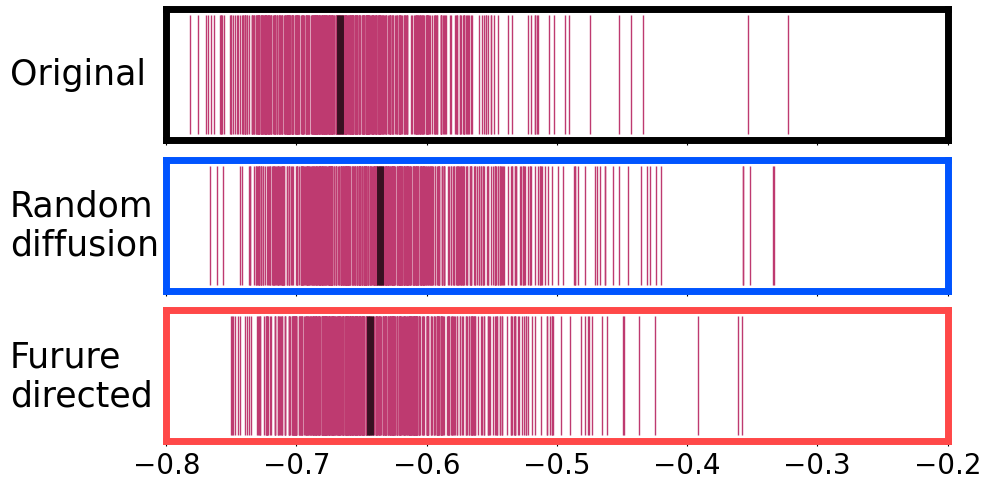

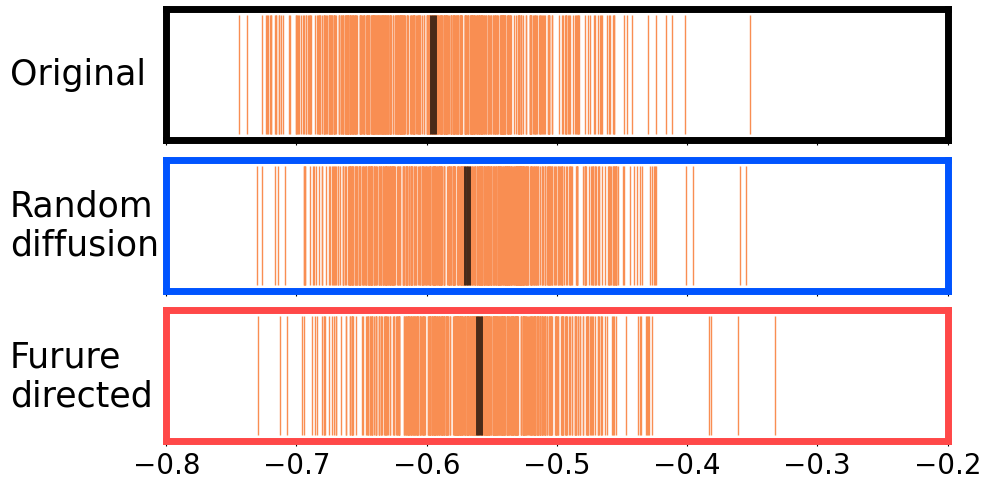

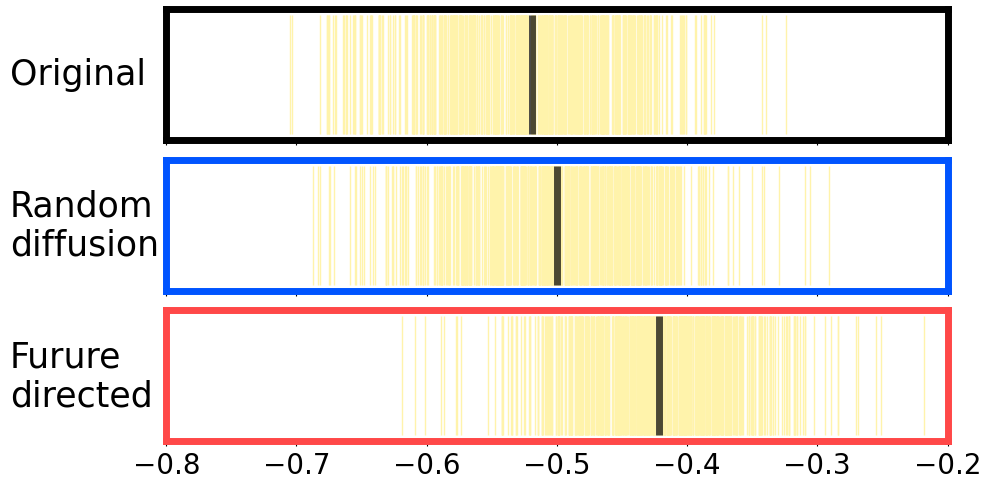

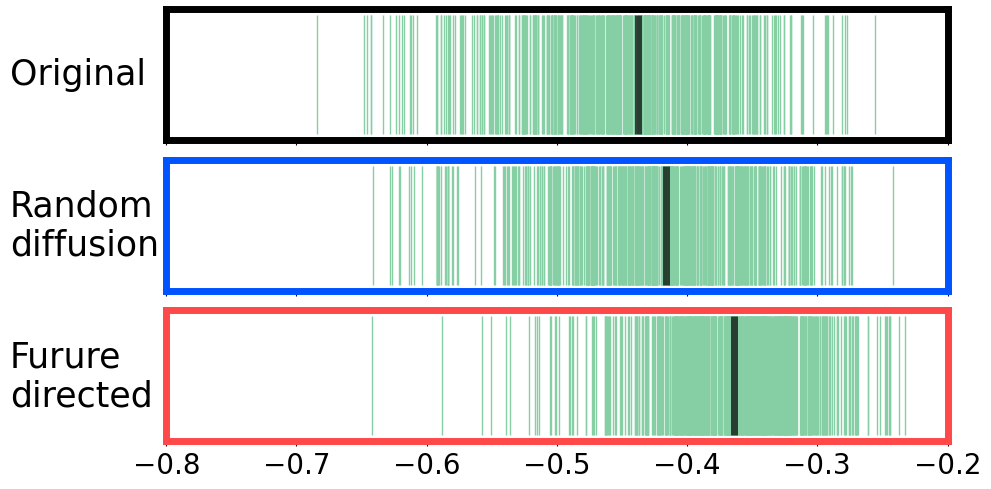

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import colorsys

# 카테고리 설정
years = [ 1500, 1600, 1700, 1800 ]
names = ['Random\ndiffusion','Furure\ndirected']

# 팔레트 설정 ('tab20' 팔레트 사용)
cmap = plt.get_cmap('Spectral')

# 서브플롯 생성
for i, year in enumerate(years):
    
    fig, axes = plt.subplots(3, 1, figsize=(10,5), sharex=True)
    color = cmap(i / len(years))  # 팔레트에서 색상 선택

    if i == 0 :
    # 색상 채도 조절
        rgb = color[:3]
        h, s, v = colorsys.rgb_to_hsv(*rgb)
        s = s*0.7
        v = min(v*1.2,1.0)
        new_rgb = colorsys.hsv_to_rgb(h, s, v)
        color = (*new_rgb, color[3])

    if i == 2 :
    # 색상 채도 조절
        rgb = color[:3]
        h, s, v = colorsys.rgb_to_hsv(*rgb)
        h = h*0.85
        s = min(s*1.3,1.0)
        new_rgb = colorsys.hsv_to_rgb(h, s, v)
        color = (*new_rgb, color[3])


    # original
    axes[0].vlines(np.array(original_time[year]), 0, 1, colors=color, lw=1)
    axes[0].vlines(np.median(np.array(original_time[year])), 0, 1, colors='black', alpha=0.7, lw=5)
    axes[0].text(-0.92, 0.5, 'Original', verticalalignment='center', fontsize=25)
    axes[0].set_xlim(-0.8,-0.2)
    axes[0].set_yticks([])
    axes[0].tick_params(axis='x', labelsize=20)
    #axes[0].set_title('Original', fontsize=20)
    
    for j, time_dict in enumerate([using_noprompt_time,using_prompt_time]) :
        ax = axes[j+1]
        try:
            temp = time_dict['step20'][year]
        except Exception as e:
            time_dict['step20'][year] = 0
        # 각 카테고리별로 개별 점 그리기
        ax.vlines(np.array(time_dict['step10'][year]), 0, 1, colors=color, lw=1)
        ax.vlines( np.median(np.array(time_dict['step10'][year])), 0, 1, colors='black', alpha=0.7, lw=5)
    
        # 카테고리 이름 추가
        ax.text(-0.92, 0.5, names[j], verticalalignment='center', fontsize=25)
        ax.set_xlim(-0.8,-0.2)
        ax.set_yticks([])
        ax.tick_params(axis='x', labelsize=20)

    # 테두리 설정
    for spine in axes[0].spines.values():
        spine.set_edgecolor('black')  # 테두리 색상 변경
        spine.set_linewidth(5)  # 테두리 두께 설정

    for spine in axes[1].spines.values():
        spine.set_edgecolor(blue_l)  # 테두리 색상 변경
        spine.set_linewidth(5)  # 테두리 두께 설정
    
    for spine in axes[2].spines.values():
        spine.set_edgecolor(red_l)  # 테두리 색상 변경
        spine.set_linewidth(5)  # 테두리 두께 설정

    fig.tight_layout()
    plt.savefig(f'/home/jinny/projects/Art-history/Art-history/graph/figure05_F_{year}.svg',bbox_inches='tight',transparent = True,dpi=600)